# Volumetric Surface Reconstruction.

In [2]:
from Dino_Images import *
from background_removal_utils import *

In [4]:
# Source files
DI = Dino_Images()

## Data Loader (Dino_images.py)

JACK/LEON

## Calculating the Fundamental Matrix F

Given two non-calibrated cameras, define camera center as $C, C'$ respectively, homogenous image points $x, x'$ respectively, and corresponding homogenous 3D point as $X$.

The goal is to find a transformation F that maps an image point in the first camera to an epipolar line in the second camera. In other words,

$$l' = Fx$$

To obtain the epipole of the right image, we need to project camera center $C$ in the first camera to the second camera's image plane,

$$e' = P'C$$

Now, to project a 3D point $X$ onto the camera-centered coordinates for the first camera, $PX = x$. If point $X$ is to be recovered, the following one-parameter equation is used:

$$X(\lambda) = P^{+}x + \lambda C$$

NOTE: Since $P$ is not square, it is using a $P^{+}$ is the pseudo-inverse.

Since $X$ is in homogenous coordinates, $\lambda = 0 \implies X = P^{+}x$ and $\lambda = \infty \implies X = C$ (which corresponds to the illegal $(0,0,0)$ case). Using the projection matrix of the second image, we get $P'X = P'P^{+}x$ and $P'C$ respectively to get points in camera center coordinates of the second camera. Note that $P'C$ is the epipole located in the second image. Calculating the cross product of these two vectors produces the normal of the epipolar plane.

$$n = (P'C)\times(P'P^{+}x)$$

Thus, finding points $x'$ such that:

$$x'n=0$$

Represents that $x'$ is on the epipolar line.


$$
\begin{align*}
x'n & = 0 \\
x'(P'C)\times(P'P^{+}x) & = 0 \\
x'[e']_{\times}P'P^{+}x = 0 \\
x'Fx = 0
\end{align*}
$$

Finally, the fundamental matrix is defined as:

$$F = [e']_{\times}P'P^+$$


## Finding Matching Pairs (openCV)

### Background Removal

In this section, we want to compare different background removal procedures to get the best result. The reason behind segementing the background from the object is to make sure we only perform 3d reconstruction on the object.

#### Historgram-Based Naive Segmentation 

A naive approach is to select the points with a cutoff threshold. Here we applied a color threshold on every pixels on the image. Pixels which have color intensity $r, g, b$ which $r + g + b < threshold$ is considered the background. 

#### Stereo Depth Matching Segmentations 

Since we have stereo images, distinguishing background from the object can be done using the depth detection algorithm in hope that the background is labelled in different depth than the object. Since the relative position between stereo camera point is small, we assume them to be at the same position. Hence, we can use the ransec on find the homogenis metrix for wrapping second image to the same plane. Here we used a simple disparity calculation using the distance between points in image plane corresponding to the scene point 3D and their camera center. We apply the epiline constraint to find matching points along the same epiline. 

#### K-Means Segamentation

Here we implemented the K-means segementation algorithm based on three pixels features, namely the intensity, x, and y location. We applied $\epilson$ on the x and y location for lowering the penalty on location inconsistency. Essentially we use $k = 3$, and initialize the k-means center by selecting the top-left, bottom-right and centre pixel. By doing so, we ensures that the object is always located in the center clustering.  

/Users/mgw/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


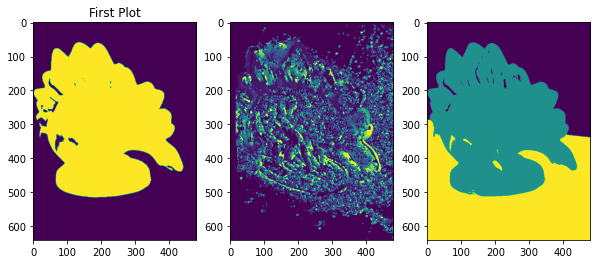

In [16]:
# Histogram-Based Segmentation
mask_naive, _ = background_remover_naive(rotate(DI.image_list[0], 90, resize = True))

# Stereo Depth Matching Segmentations
imgL_rotate = img_as_ubyte(rotate(DI.image_list[0], 90, resize = True))
imgR_rotate = img_as_ubyte(rotate(DI.image_list[1], 90, resize = True))
mask_depth, _ = background_remover_depth(imgL_rotate, imgR_rotate, DI.T_Matrix[0], DI.T_Matrix[1])

# K-Means Segamentation
mask_km = background_remover_k_clustering(rotate(DI.image_list[0], 90, resize = True))


plt.figure(4,figsize = (10, 4))

ax1 = plt.subplot(131)
plt.imshow(mask_naive)
ax1.title.set_text('Histogram-Based Segmentation')
ax1.
ax2 = plt.subplot(132)
plt.imshow(mask_depth)
ax2.title.set_text('Stereo Depth Matching Segmentations')

ax3 = plt.subplot(133)
plt.imshow(mask_km)
ax2.title.set_text('K-Means Segamentation')


In [10]:
mask_km = background_remover_k_clustering(rotate(DI.image_list[0], 90, resize = True))


/Users/mgw/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


#### Auto Background Removel by Adobe

We also used the auto background segementation algorithm provided in Adobe Photoshop. This approch is consisted with using a deep neural network encoder and decoder structure. The network is trained with a data set of 49,300 images, and the algorithm seems to have learned well. https://arxiv.org/pdf/1703.03872.pdf. The sturecture of the neural network is as followed:

We use the Adobe photoshop action tools to automate the entire background removal process in one click. Some of the result are shown as followed:

[INSERT MODELS]

![title](imgs/encoderdecoderadobe.png)

### Pair Matching

For a given dots on the first images denoted by $x_i$, is possible to find a corrospounding epipolar line $l_i$ on the second image given the fundimental matrix $F$. The navie approach is to perform pattern matching using colour intensity along the epipolar line. However, it is still difficult challenging to find the true matching pairs on the second images due to the following reasons:
* Error in fundimental matrix estimation
* Error in epipolar line $l_i$ estimation

Hence, it is very important to come up with a robust way of finding the matched point.

#### Convolutional Absolute Intensity Difference Method

First of all, we implementated a simple method where similar to the integral image (but with pixel $p$ being the center of the bounding box size), the  was calculated for all points on $l_i$ and compared with the integral image on point $p\in x_i$ in the first image (given a bounding box size of $2*bbr$ where $bbr$ is the bounding box radius). Then the points on $l_i$ that minimizes the sum of the absolute differences of the intensities was taken to be the matching pair. In other words given $p\in x_i$ find $q\in l_i$ such that:

$$
\begin{align*}
\arg\min_{q} \sum{\left|I_{cropped}(p) - I_{cropped}(q)\right|}
\end{align*}
$$

where $I_{cropped}$ is the cropped image with center pixel at $x_i$ and size $(2*bbr+1,2*bbr+1)$



#### Normalized Linear Kernal Correlation Coefficient Method

Secondly, we tries to implement the correlation coefficient method described in the [https://docs.opencv.org/4.x/df/dfb/group__imgproc__object.html#gga3a7850640f1fe1f58fe91a2d7583695daf9c3ab9296f597ea71f056399a5831da](CCOFE_NORM).  Assume that $T(x, y), I(x, y)$ gives the pixel intensity on the template / matching image with position $(x, y)$. Similarity score $R(x, y)$ is given by the normalization function $R(x, y) = \frac{\sum_{x', y'}(T(x', y') \cdot I'(x+x', y+y'))}{\sqrt{\sum_{x', y'}T(x', y')^2 \cdot I'(x+x', y+y')^2}}$ by convolutionaly going through the image. Here $T'(x', y') = M(x', y') \cdot (T(x', y') - \frac{\sum_{x'', y''}(T(x'', y'') \cdot M(x'', y''))}{\sum_{x'', y''}T(x'', y'')})$, $I(x' + x, y' + y) = M(x', y') \cdot (I(x' + x, y' + y) - \frac{\sum_{x'', y''}(I(x'' + x, y'' + y) \cdot M(x'', y''))}{\sum_{x'', y''}T(x'', y'')})$

We first calculate the score matrix, then the goal is to optimize the score along and near the epipolar line $y = l(x)$. We implemented a pair wise optimization function using the correlation coefficient score matrix $\mathbb{S}$ and horizontal shift $f$ from the epipolar line. We are trying to optimize the following by finding point $x, y$:
$$
L = \mathbb{S}_{x + f, l(x) + f} \cdot (1 - |f| \cdot epsilon)
$$

### Preliminary Outlier Detection

#### Spatial Consistency between different epipolar lines

When matching points from the left to the right image using epipolar lines, it might be the case that the matched point is far away from the original point on the left image since we are using photo consistency to match (a pixel with a similar neighborhood may be on the epipolar line). To counteract this effect, we first match the starting and ending of points of the region we are matching points from. Next, when matching a given point $x$, we add that a penalty that is proportional to the distance from the point to the line between the start and end points. The distance can be computed with the formula

$$
    ||x, L|| = ||x - (p + \frac{(x - p)\cdot (p - q)}{||p - q||}(p - q))||
$$

where $L$ is the between the start and end points $p$ and $q$ of the region we are matching in.

This penalty is weighted by a parameter 'delta' which can be changed in the get_match_points_linspace function. The default value is currently very small, as we need the penalty to be of the same magnitude as the cv2.matchTemplate function we used that judges how well a section of the image matches by photo consistency.

#### Spatial Consistency between within the epipolar line

Given a point in the first image, there were instances where the derived epipolar line was:

- out of the image plane
- within the image plane but did not touch the object

In order to minimize these errors, we made sure to proceed with a point in the left image if and only if the corresponding epipolar line consists of at least $T=3$ amount of points that are on the object. This mask was created originally when sampling points on the object.

### Triangulation

Given a pair of homogenous matching points $x,x'$ that corresponds to an unknown homogenous 3D point $\mathbf{X}$ and projection matrices $P,P'$, triangulation can be done in order to determine the 3D point $\mathbf{X}$.

Define

$$
\begin{equation*}
P = 
\begin{bmatrix}
r_{11} & r_{12} & r_{13} & t_{1} \\
r_{21} & r_{22} & r_{23} & t_{2} \\
r_{31} & r_{32} & r_{33} & t_{3}
\end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
P' = 
\begin{bmatrix}
r_{11}' & r_{12}' & r_{13}' & t_{1}' \\
r_{21}' & r_{22}' & r_{23}' & t_{2}' \\
r_{31}' & r_{32}' & r_{33}' & t_{3}'
\end{bmatrix}
\end{equation*}
$$

and 

$$
\mathbf{X} =
\begin{bmatrix}
X \\
Y \\
Z \\
1 
\end{bmatrix}$$

and

$$
x =
\begin{bmatrix}
u \\
v \\
1 
\end{bmatrix}$$

$$
x' =
\begin{bmatrix}
u' \\
v' \\
1 
\end{bmatrix}$$

Then by definition,

$$x = PX$$ $$x' = P'X$$

Thus, taking the cross product results in:

$$x \times PX = 0$$ $$x' \times PX' = 0$$

Rewriting in terms of the projection matrices' rows yields:

$$
\begin{array}{cc}
x(\mathbf{p_3}^T \mathbf{X})-(\mathbf{p_1}^T \mathbf{X}) \\
y(\mathbf{p_3}^T \mathbf{X})-(\mathbf{p_2}^T \mathbf{X}) \\
x(\mathbf{p_2}^T \mathbf{X})-y(\mathbf{p_1}^T \mathbf{X})
\end{array}
$$

Taking the two linearly independent rows and using the two image points yields the following system of linear equations:

$$
A = \left[ \begin{array}{cc}
x(\mathbf{p_3}^T)-(\mathbf{p_1}^T) \\
y(\mathbf{p_3}^T)-(\mathbf{p_2}^T) \\
x'(\mathbf{p_3}^T)-(\mathbf{p_1}^T) \\
y'(\mathbf{p_3}^T)-(\mathbf{p_2}^T)
\end{array}
\right]
$$

where we are solving for $A\mathbf{X} = 0$.

Using the inhomogenous least squares route:

$$X = (A'A)^{-1}A'B$$

where $$A = A_{1:3}[X_1,X_2,X_3]^T, B = A_{4}$$

(from assignment)


### Sequential Update

- LEON

### Outlier Detection

Although the matching image points were projected onto the 3D world coordinate system, there are always reprojection errors to consider. Those outliers will be determental in the step where the silhouette is created. Thus, there needed to be a method of removing these outliers. Here are some approaches we considered:

- Distance cutoff on the distance between points and mean/median
- K-means on the distance between points and mean/median
- Multivariate Gaussian Distribution
- Gaussian Mixture Models
- One nearest neighbor
- IQR test


From here on out $X$ is a point in the 3d world coordinate system unless stated otherwise.

#### Distance Metrics

Generally, when projecting a large number of points, it can be assumed that the majority of the 3D points will be in the shape of the object. Thus, outliers will be substantially further from the majority of the points. One approach was a simple thresholdcutoff. Taking either the mean or median $\bar{X}$ and given a threshold $T_{dist}$, only points satisfying the condition below were taken:

$$dist(X, \bar{X}) < T_{dist}$$

Though this is a naive approach, it works well in practice. Another way of implementing the threshold was applying the K-means algorithm. Taking either the mean or median $\bar{X}$, the distance between each $X$ and $\bar{X}$ was calculated. Then, the K-means algorithm was applied with a large number of clusters $k$. The idea here is outliers will be in clusters that are very small. Thus, points $X$ in cluster $C_i$ was taken if the size of $C_i$ is greater than a threshold $T_{kmeans}$. In other words:

$$|C_i| > T_{kmeans}$$

Another possible distance metric used was one-nearest neighbor algorithm. For every point, the distance between itself and the nearest point was calculated. Given a threshold $T_{nn}$, if the distance is short enough, the points were kept. In other words:

$$dist(X, X_{closest}) < T_{nn}$$


#### Gaussian Metrics

If a multivariate gaussian was fit on the data points, points further away from the mean would imply that it is unlikely for the outliers to come from the fitted distribution. Thus, a multivariate gaussian model was fit with CDF $F$ and a threshold of probability $p_g$ such that points were taken if:

$$p_g<F(X)<1-p_g$$

However, using a single gaussian model may not be the best approach as the points on the object may not follow a single gaussian distribution. Thus, a gaussian mixture model was used in order to improve the accuracy of detecting the outliers. We fit $k$ components onto the data and computed the log-likelihood $l(X)$. Then a threshold of probability $p_{gmm}$ such that point were taken if:

$$l(X) < p_{gmm}$$

#### Other Metrics

Taking inspiration from statistics, the inter-quartile range was used to eliminate prelimenary outliers. In other words, given the first and third quantiles $Q1$ and $Q3$ respectively we can calculate the $IQR = Q3-Q1$. We only keep points if:

$$Q1 - 1.5 IQR < X < Q3 + 1.5 IQR$$


### Concave Optimization

### References

### References

- Ghosh, Sourish. “Calculating the Fundamental Matrix from Camera Matrices.” Sourish Ghosh, https://sourishghosh.com/2016/fundamental-matrix-from-camera-matrices/.
- Wu, Kai. Triangulation, https://imkaywu.github.io/blog/2017/07/triangulation/. 
- Xu, Ning, et al. "Deep image matting." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.